# PyTorchTuto_4.ipynb

## Author: Akshay Anand, PhD Candidate  
**Florida State University (2021 - 20XX)**
[*Github*](https://github.com/anand-me)
---

## Introduction  

Welcome to the fourth notebook in the PyTorch tutorial series! In this session, we will build upon the concepts introduced in the previous notebooks and explore the training process in PyTorch.

This notebook will focus on:  
1. **Training Models**  
   - Loss Functions
   - Optimizers
   - Training Loops

By the end of this notebook, you will understand how to effectively train neural networks using PyTorch's optimization tools and best practices.  

---

Let’s get started!

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
from IPython.display import clear_output

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Enable plots in the notebook
%matplotlib inline

In [4]:
print(f"PyTorch version: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
Using device: cpu


In [5]:
# ============================================================================ #
#                                1. LOSS FUNCTIONS                              #
# ============================================================================ #

print("\n" + "="*80)
print("1. LOSS FUNCTIONS".center(80))
print("="*80)

# ---------------------------------------------------------------------------- #
#                         Understanding Loss Functions                          #
# ---------------------------------------------------------------------------- #

print("\n📌 What are Loss Functions?")
print("Loss functions measure how far our model's predictions are from the true values.")
print("They provide the signal for updating model parameters during training.")

print("\n📝 Common Loss Functions in PyTorch:")



                               1. LOSS FUNCTIONS                                

📌 What are Loss Functions?
Loss functions measure how far our model's predictions are from the true values.
They provide the signal for updating model parameters during training.

📝 Common Loss Functions in PyTorch:


In [6]:
# Create some sample data
# For regression problems
y_true_reg = torch.tensor([0.5, 1.5, 2.5, 3.5, 4.5])
y_pred_reg1 = torch.tensor([0.4, 1.3, 2.3, 3.2, 4.3])  # Good predictions
y_pred_reg2 = torch.tensor([1.5, 2.5, 1.5, 5.0, 3.0])  # Poor predictions

In [7]:
# For binary classification
y_true_bin = torch.tensor([0, 1, 0, 1, 0], dtype=torch.float32)
y_pred_bin_good = torch.tensor([0.1, 0.9, 0.2, 0.8, 0.1], dtype=torch.float32)
y_pred_bin_bad = torch.tensor([0.7, 0.3, 0.6, 0.2, 0.8], dtype=torch.float32)

In [8]:
# For multi-class classification (one-hot encoded targets)
y_true_multi = torch.tensor([0, 2, 1, 1, 3])
# Convert to one-hot encoding for some loss functions
y_true_multi_onehot = F.one_hot(y_true_multi, num_classes=4).float()
# Predicted probabilities (good)
y_pred_multi_good = torch.tensor([
    [0.9, 0.05, 0.03, 0.02],  # Predicts class 0
    [0.05, 0.05, 0.85, 0.05],  # Predicts class 2
    [0.05, 0.85, 0.05, 0.05],  # Predicts class 1
    [0.05, 0.80, 0.05, 0.10],  # Predicts class 1
    [0.05, 0.05, 0.05, 0.85]   # Predicts class 3
])
# Predicted probabilities (bad)
y_pred_multi_bad = torch.tensor([
    [0.2, 0.3, 0.3, 0.2],     # Uncertain prediction
    [0.6, 0.3, 0.05, 0.05],   # Wrong prediction (class 0 instead of 2)
    [0.7, 0.1, 0.1, 0.1],     # Wrong prediction (class 0 instead of 1)
    [0.25, 0.25, 0.25, 0.25], # Very uncertain prediction
    [0.4, 0.4, 0.1, 0.1]      # Wrong prediction (not class 3)
])

In [9]:
# ---------------------------------------------------------------------------- #
#                          1.1 Regression Loss Functions                        #
# ---------------------------------------------------------------------------- #

print("\n📊 1.1 Regression Loss Functions:")


📊 1.1 Regression Loss Functions:


In [10]:
# Mean Squared Error (MSE)
mse_loss = nn.MSELoss()
mse_good = mse_loss(y_pred_reg1, y_true_reg)
mse_bad = mse_loss(y_pred_reg2, y_true_reg)
print(f"  • Mean Squared Error (MSE)")
print(f"    - Good predictions MSE: {mse_good.item():.4f}")
print(f"    - Poor predictions MSE: {mse_bad.item():.4f}")

  • Mean Squared Error (MSE)
    - Good predictions MSE: 0.0440
    - Poor predictions MSE: 1.5000


In [11]:
# Mean Absolute Error (L1 Loss)
mae_loss = nn.L1Loss()
mae_good = mae_loss(y_pred_reg1, y_true_reg)
mae_bad = mae_loss(y_pred_reg2, y_true_reg)
print(f"\n  • Mean Absolute Error (L1)")
print(f"    - Good predictions MAE: {mae_good.item():.4f}")
print(f"    - Poor predictions MAE: {mae_bad.item():.4f}")


  • Mean Absolute Error (L1)
    - Good predictions MAE: 0.2000
    - Poor predictions MAE: 1.2000


In [12]:
# Smooth L1 Loss (Huber Loss)
smooth_l1_loss = nn.SmoothL1Loss()
smooth_l1_good = smooth_l1_loss(y_pred_reg1, y_true_reg)
smooth_l1_bad = smooth_l1_loss(y_pred_reg2, y_true_reg)
print(f"\n  • Smooth L1 Loss (Huber)")
print(f"    - Good predictions Smooth L1: {smooth_l1_good.item():.4f}")
print(f"    - Poor predictions Smooth L1: {smooth_l1_bad.item():.4f}")



  • Smooth L1 Loss (Huber)
    - Good predictions Smooth L1: 0.0220
    - Poor predictions Smooth L1: 0.7000


In [13]:
# Visualizing regression losses
x = torch.linspace(-3, 3, 1000)
y_true = torch.zeros_like(x)

In [14]:
# Calculate different losses
mse_values = (x - y_true)**2
mae_values = torch.abs(x - y_true)
# Huber loss with delta=1
delta = 1.0
huber_values = torch.where(
    torch.abs(x - y_true) < delta,
    0.5 * (x - y_true)**2,
    delta * (torch.abs(x - y_true) - 0.5 * delta)
)

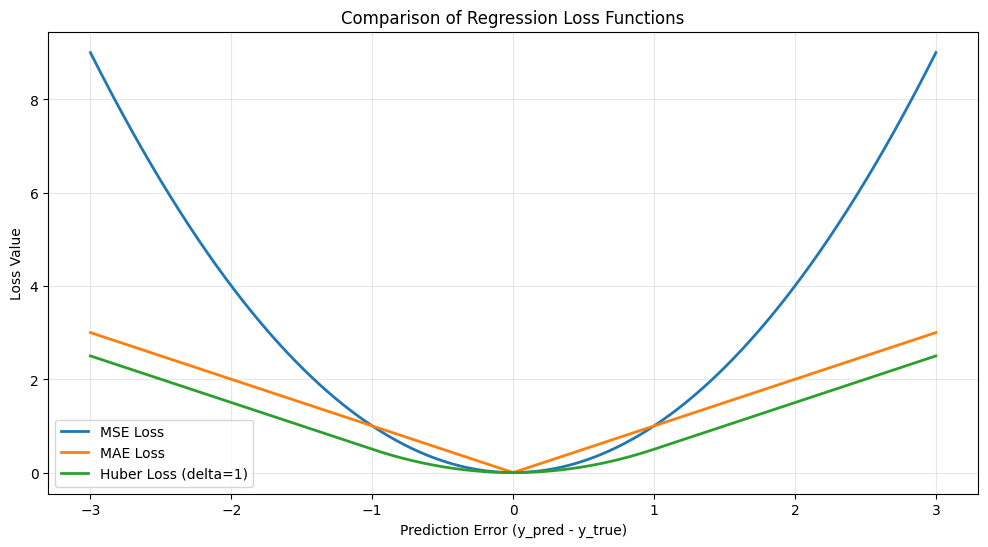

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(x.numpy(), mse_values.numpy(), label='MSE Loss', linewidth=2)
plt.plot(x.numpy(), mae_values.numpy(), label='MAE Loss', linewidth=2)
plt.plot(x.numpy(), huber_values.numpy(), label='Huber Loss (delta=1)', linewidth=2)
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Comparison of Regression Loss Functions')
plt.xlabel('Prediction Error (y_pred - y_true)')
plt.ylabel('Loss Value')
plt.show()

In [16]:
# ---------------------------------------------------------------------------- #
#                    1.2 Binary Classification Loss Functions                   #
# ---------------------------------------------------------------------------- #

print("\n📊 1.2 Binary Classification Loss Functions:")



📊 1.2 Binary Classification Loss Functions:


In [17]:
# Binary Cross Entropy
bce_loss = nn.BCELoss()
bce_good = bce_loss(y_pred_bin_good, y_true_bin)
bce_bad = bce_loss(y_pred_bin_bad, y_true_bin)
print(f"  • Binary Cross Entropy (BCE)")
print(f"    - Good predictions BCE: {bce_good.item():.4f}")
print(f"    - Poor predictions BCE: {bce_bad.item():.4f}")


  • Binary Cross Entropy (BCE)
    - Good predictions BCE: 0.1525
    - Poor predictions BCE: 1.3086


In [18]:
# BCE with Logits (combines sigmoid and BCE)
# Convert to logits (log-odds) for BCE with Logits
y_pred_bin_good_logits = torch.log(y_pred_bin_good / (1 - y_pred_bin_good))
y_pred_bin_bad_logits = torch.log(y_pred_bin_bad / (1 - y_pred_bin_bad))

bce_logits_loss = nn.BCEWithLogitsLoss()
bce_logits_good = bce_logits_loss(y_pred_bin_good_logits, y_true_bin)
bce_logits_bad = bce_logits_loss(y_pred_bin_bad_logits, y_true_bin)
print(f"\n  • BCE with Logits")
print(f"    - Good predictions BCE with Logits: {bce_logits_good.item():.4f}")
print(f"    - Poor predictions BCE with Logits: {bce_logits_bad.item():.4f}")



  • BCE with Logits
    - Good predictions BCE with Logits: 0.1525
    - Poor predictions BCE with Logits: 1.3086


In [19]:
# Visualizing Binary Classification Loss
# Generate probability values from 0 to 1
p = torch.linspace(0.001, 0.999, 1000)


In [20]:
# Calculate BCE loss for y=1 and y=0
bce_y1 = -torch.log(p)
bce_y0 = -torch.log(1 - p)

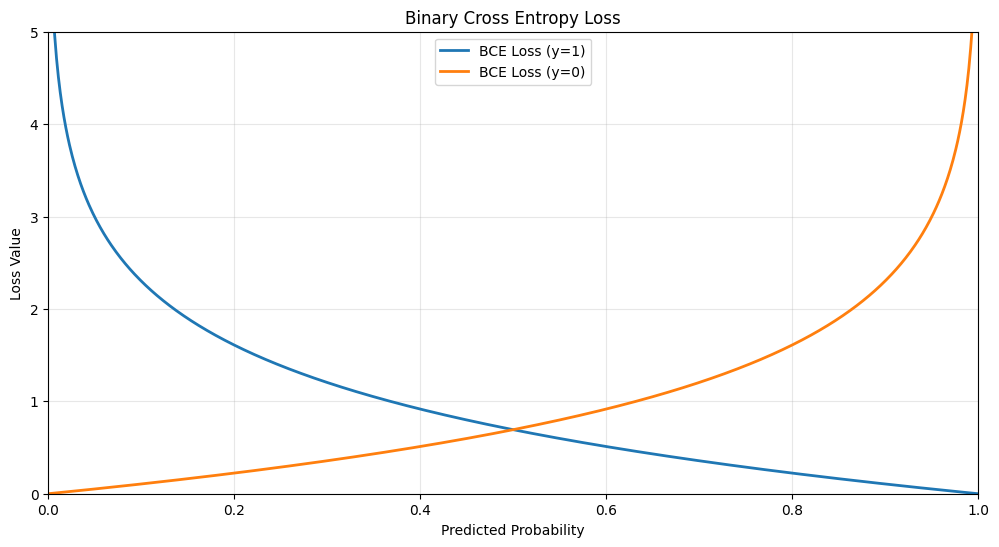

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(p.numpy(), bce_y1.numpy(), label='BCE Loss (y=1)', linewidth=2)
plt.plot(p.numpy(), bce_y0.numpy(), label='BCE Loss (y=0)', linewidth=2)
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Binary Cross Entropy Loss')
plt.xlabel('Predicted Probability')
plt.ylabel('Loss Value')
plt.xlim(0, 1)
plt.ylim(0, 5)
plt.show()

In [22]:
# ---------------------------------------------------------------------------- #
#                  1.3 Multi-class Classification Loss Functions                #
# ---------------------------------------------------------------------------- #

print("\n📊 1.3 Multi-class Classification Loss Functions:")



📊 1.3 Multi-class Classification Loss Functions:


In [23]:
# Cross Entropy Loss
ce_loss = nn.CrossEntropyLoss()
# For CrossEntropyLoss, we need class indices as targets (not one-hot)
# and logits (raw scores) as predictions
ce_good = ce_loss(y_pred_multi_good, y_true_multi)
ce_bad = ce_loss(y_pred_multi_bad, y_true_multi)
print(f"  • Cross Entropy")
print(f"    - Good predictions Cross Entropy: {ce_good.item():.4f}")
print(f"    - Poor predictions Cross Entropy: {ce_bad.item():.4f}")

  • Cross Entropy
    - Good predictions Cross Entropy: 0.8538
    - Poor predictions Cross Entropy: 1.5115


In [24]:
# Kullback-Leibler Divergence Loss
kl_loss = nn.KLDivLoss(reduction='batchmean')
# KLDivLoss expects log probabilities as input
y_pred_multi_good_log = torch.log(y_pred_multi_good)
y_pred_multi_bad_log = torch.log(y_pred_multi_bad)
kl_good = kl_loss(y_pred_multi_good_log, y_true_multi_onehot)
kl_bad = kl_loss(y_pred_multi_bad_log, y_true_multi_onehot)
print(f"\n  • KL Divergence")
print(f"    - Good predictions KL Divergence: {kl_good.item():.4f}")
print(f"    - Poor predictions KL Divergence: {kl_bad.item():.4f}")


  • KL Divergence
    - Good predictions KL Divergence: 0.1632
    - Poor predictions KL Divergence: 2.1193


In [25]:
# ---------------------------------------------------------------------------- #
#                         1.4 Custom Loss Functions                             #
# ---------------------------------------------------------------------------- #

print("\n📊 1.4 Custom Loss Functions:")
print("  • You can create custom loss functions by extending nn.Module")
print("  • Or by defining a function that operates on tensors")


📊 1.4 Custom Loss Functions:
  • You can create custom loss functions by extending nn.Module
  • Or by defining a function that operates on tensors


In [26]:
# Example: Focal Loss (custom implementation)
# Helps with class imbalance by reducing the loss contribution from easy examples
def focal_loss(predictions, targets, gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Args:
        predictions: Tensor of predicted probabilities
        targets: Tensor of ground truth labels (0 or 1)
        gamma: Focusing parameter (higher means more focus on hard examples)
        alpha: Weighting factor for the positive class

    Returns:
        Computed focal loss
    """
    # Ensure predictions are probabilities
    predictions = torch.clamp(predictions, min=1e-7, max=1-1e-7)

    # Binary cross entropy component
    bce = -targets * torch.log(predictions) - (1 - targets) * torch.log(1 - predictions)

    # Focal component
    pt = torch.where(targets == 1, predictions, 1 - predictions)
    focal_weight = (1 - pt) ** gamma

    # Apply alpha weighting
    alpha_weight = torch.where(targets == 1, alpha, 1 - alpha)

    # Combine all components
    loss = alpha_weight * focal_weight * bce

    return loss.mean()

In [27]:
# Let's compare standard BCE vs Focal Loss
focal_good = focal_loss(y_pred_bin_good, y_true_bin)
focal_bad = focal_loss(y_pred_bin_bad, y_true_bin)
print(f"\n  • Focal Loss Comparison:")
print(f"    - Standard BCE (good predictions): {bce_good.item():.4f}")
print(f"    - Focal Loss (good predictions): {focal_good.item():.4f}")
print(f"    - Standard BCE (poor predictions): {bce_bad.item():.4f}")
print(f"    - Focal Loss (poor predictions): {focal_bad.item():.4f}")
print(f"    - Notice how Focal Loss emphasizes hard examples")



  • Focal Loss Comparison:
    - Standard BCE (good predictions): 0.1525
    - Focal Loss (good predictions): 0.0022
    - Standard BCE (poor predictions): 1.3086
    - Focal Loss (poor predictions): 0.3735
    - Notice how Focal Loss emphasizes hard examples


In [28]:
# Create a class-based custom loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=None):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight

    def forward(self, predictions, targets):
        if self.weight is None:
            return torch.mean((predictions - targets) ** 2)
        else:
            return torch.mean(self.weight * (predictions - targets) ** 2)

In [29]:
# Example with weighted MSE loss
weights = torch.tensor([0.5, 1.0, 1.5, 2.0, 2.5])  # Higher weights for later samples
weighted_mse = WeightedMSELoss(weight=weights)
weighted_mse_good = weighted_mse(y_pred_reg1, y_true_reg)
weighted_mse_bad = weighted_mse(y_pred_reg2, y_true_reg)

print(f"\n  • Weighted MSE (Custom Loss):")
print(f"    - Standard MSE (good predictions): {mse_good.item():.4f}")
print(f"    - Weighted MSE (good predictions): {weighted_mse_good.item():.4f}")
print(f"    - Standard MSE (poor predictions): {mse_bad.item():.4f}")
print(f"    - Weighted MSE (poor predictions): {weighted_mse_bad.item():.4f}")


  • Weighted MSE (Custom Loss):
    - Standard MSE (good predictions): 0.0440
    - Weighted MSE (good predictions): 0.0770
    - Standard MSE (poor predictions): 1.5000
    - Weighted MSE (poor predictions): 2.6250


In [30]:
# ============================================================================ #
#                                  2. OPTIMIZERS                                #
# ============================================================================ #

print("\n" + "="*80)
print("2. OPTIMIZERS".center(80))
print("="*80)

# ---------------------------------------------------------------------------- #
#                         Understanding Optimizers                              #
# ---------------------------------------------------------------------------- #


                                 2. OPTIMIZERS                                  


In [31]:
print("\n📌 What are Optimizers?")
print("Optimizers adjust model parameters based on the computed gradients to minimize the loss function.")
print("They implement different algorithms for updating weights during training.")


📌 What are Optimizers?
Optimizers adjust model parameters based on the computed gradients to minimize the loss function.
They implement different algorithms for updating weights during training.


In [32]:
# ---------------------------------------------------------------------------- #
#                           2.1 Common Optimizers                               #
# ---------------------------------------------------------------------------- #

print("\n📊 2.1 Common Optimizers in PyTorch:")



📊 2.1 Common Optimizers in PyTorch:


In [33]:
# Create a simple model to demonstrate optimizers
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [34]:
# Create multiple instances of the same model
model_sgd = SimpleModel()
model_momentum = SimpleModel()
model_adagrad = SimpleModel()
model_rmsprop = SimpleModel()
model_adam = SimpleModel()

In [35]:
# Copy parameters to ensure all models start from the same point
with torch.no_grad():
    for param_sgd, param_momentum, param_adagrad, param_rmsprop, param_adam in zip(
        model_sgd.parameters(),
        model_momentum.parameters(),
        model_adagrad.parameters(),
        model_rmsprop.parameters(),
        model_adam.parameters()):

        # Initialize with the same parameters
        init_param = torch.randn_like(param_sgd)
        param_sgd.copy_(init_param)
        param_momentum.copy_(init_param)
        param_adagrad.copy_(init_param)
        param_rmsprop.copy_(init_param)
        param_adam.copy_(init_param)


In [36]:
# Create different optimizers
sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
momentum = optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.9)
adagrad = optim.Adagrad(model_adagrad.parameters(), lr=0.01)
rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.01)
adam = optim.Adam(model_adam.parameters(), lr=0.01)

print("\n  • Stochastic Gradient Descent (SGD)")
print(f"    {sgd}")
print("\n  • SGD with Momentum")
print(f"    {momentum}")
print("\n  • Adagrad")
print(f"    {adagrad}")
print("\n  • RMSprop")
print(f"    {rmsprop}")
print("\n  • Adam")
print(f"    {adam}")


  • Stochastic Gradient Descent (SGD)
    SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

  • SGD with Momentum
    SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

  • Adagrad
    Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    fused: None
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    maximize: False
    weight_decay: 0
)

  • RMSprop
    RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

  • Adam
    Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    c

In [37]:
# ---------------------------------------------------------------------------- #
#                       2.2 Comparing Optimizers                                #
# ---------------------------------------------------------------------------- #

print("\n📊 2.2 Comparing Optimizer Performance:")



📊 2.2 Comparing Optimizer Performance:


In [38]:
# Create synthetic data for a simple regression problem
np.random.seed(42)
X = np.random.rand(1000, 2) * 10
y = 3 * X[:, 0] + 2 * X[:, 1] + 1 + np.random.randn(1000) * 2


In [39]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Loss function
criterion = nn.MSELoss()

In [40]:
# Training loop for comparing optimizers
epochs = 100
optimizers = {
    'SGD': (model_sgd, sgd),
    'Momentum': (model_momentum, momentum),
    'Adagrad': (model_adagrad, adagrad),
    'RMSprop': (model_rmsprop, rmsprop),
    'Adam': (model_adam, adam)
}


In [41]:
history = {name: [] for name in optimizers.keys()}

Epoch 20/100
  • SGD: Loss = 439.5869
  • Momentum: Loss = 135.5958
  • Adagrad: Loss = 1121.7898
  • RMSprop: Loss = 122.7247
  • Adam: Loss = 900.4960
Epoch 40/100
  • SGD: Loss = 277.4005
  • Momentum: Loss = 115.5177
  • Adagrad: Loss = 1048.1631
  • RMSprop: Loss = 54.8835
  • Adam: Loss = 573.2273
Epoch 60/100
  • SGD: Loss = 187.6694
  • Momentum: Loss = 115.8036
  • Adagrad: Loss = 993.7632
  • RMSprop: Loss = 28.2745
  • Adam: Loss = 292.9311
Epoch 80/100
  • SGD: Loss = 147.6763
  • Momentum: Loss = 115.6287
  • Adagrad: Loss = 948.7806
  • RMSprop: Loss = 14.5834
  • Adam: Loss = 127.2718
Epoch 100/100
  • SGD: Loss = 129.8513
  • Momentum: Loss = 115.5080
  • Adagrad: Loss = 909.4559
  • RMSprop: Loss = 8.5374
  • Adam: Loss = 79.7549


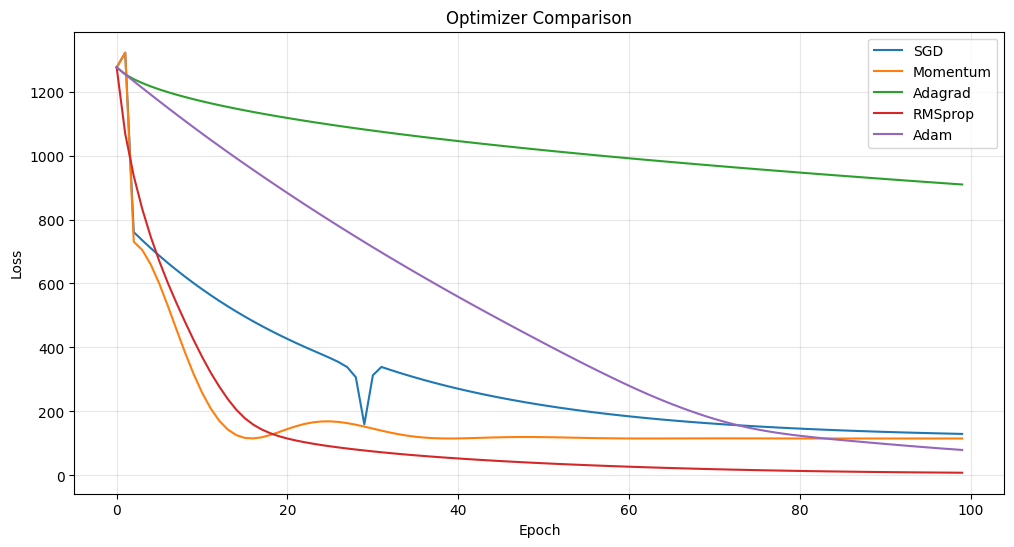

In [42]:
for epoch in range(epochs):
    for name, (model, optimizer) in optimizers.items():
        # Forward pass
        y_pred = model(X_tensor)
        loss = criterion(y_pred, y_tensor)

        # Record loss
        history[name].append(loss.item())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print progress every 10 epochs
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}")
        for name in optimizers.keys():
            print(f"  • {name}: Loss = {history[name][-1]:.4f}")

# Plot the learning curves
plt.figure(figsize=(12, 6))
for name, losses in history.items():
    plt.plot(losses, label=name)
plt.title('Optimizer Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
# ---------------------------------------------------------------------------- #
#                       2.3 Learning Rate Scheduling                            #
# ---------------------------------------------------------------------------- #

print("\n📊 2.3 Learning Rate Scheduling:")
print("  • Learning rate schedulers adjust the learning rate during training")
print("  • Common strategies: time-based decay, step decay, exponential decay")



📊 2.3 Learning Rate Scheduling:
  • Learning rate schedulers adjust the learning rate during training
  • Common strategies: time-based decay, step decay, exponential decay


In [44]:
# Create a new model for demonstration
model_scheduler = SimpleModel()

In [45]:
# Create optimizer
optimizer = optim.SGD(model_scheduler.parameters(), lr=0.1)

In [46]:
# Create different types of schedulers
step_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
exp_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


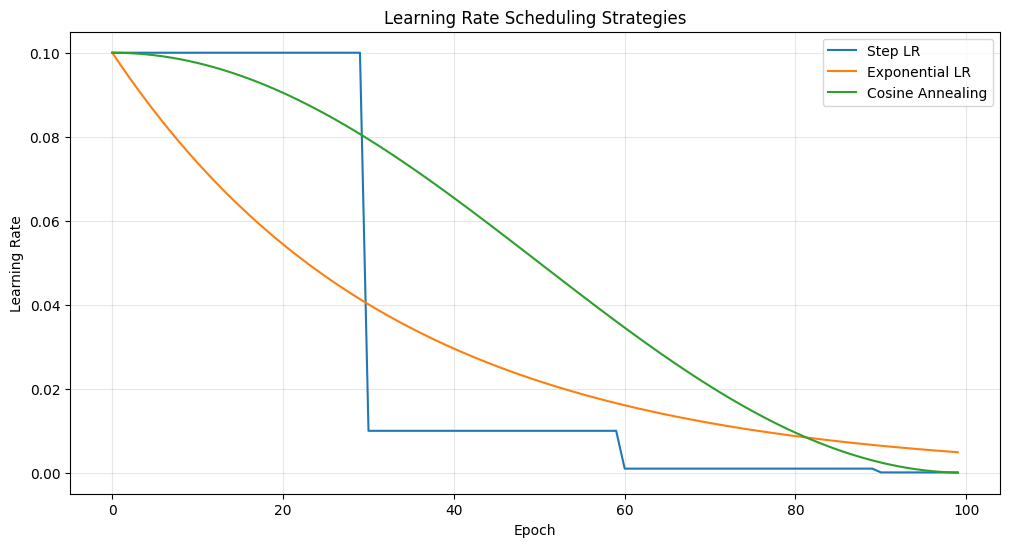

In [47]:
# Let's visualize the learning rate schedules
epochs = 100
lr_history = {
    'Step LR': [],
    'Exponential LR': [],
    'Cosine Annealing': []
}

# Reset optimizer's learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.1

# Step LR Schedule
step_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(epochs):
    lr_history['Step LR'].append(optimizer.param_groups[0]['lr'])
    step_scheduler.step()

# Reset optimizer's learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.1

# Exponential LR Schedule
exp_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
for epoch in range(epochs):
    lr_history['Exponential LR'].append(optimizer.param_groups[0]['lr'])
    exp_scheduler.step()

# Reset optimizer's learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.1

# Cosine Annealing LR Schedule
cosine_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
for epoch in range(epochs):
    lr_history['Cosine Annealing'].append(optimizer.param_groups[0]['lr'])
    cosine_scheduler.step()

# Plot the learning rate schedules
plt.figure(figsize=(12, 6))
for name, lr_values in lr_history.items():
    plt.plot(lr_values, label=name)
plt.title('Learning Rate Scheduling Strategies')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [48]:
# ============================================================================ #
#                                 3. TRAINING LOOPS                             #
# ============================================================================ #

print("\n" + "="*80)
print("3. TRAINING LOOPS".center(80))
print("="*80)



                               3. TRAINING LOOPS                                


In [49]:
# ---------------------------------------------------------------------------- #
#                       3.1 Basic Training Loop                                 #
# ---------------------------------------------------------------------------- #

print("\n📌 3.1 Basic Training Loop:")
print("  • The training loop is where everything comes together")
print("  • Core components: forward pass, loss computation, backward pass, parameter updates")



📌 3.1 Basic Training Loop:
  • The training loop is where everything comes together
  • Core components: forward pass, loss computation, backward pass, parameter updates


In [50]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [51]:
# Load smaller subsets of data for quick demonstration
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Use a smaller subset for faster execution
train_subset, _ = random_split(train_dataset, [10000, 50000])
test_subset, _ = random_split(test_dataset, [1000, 9000])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.72MB/s]


In [52]:
# Define a simple CNN model
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [53]:
# Instantiate the model
model = MnistCNN().to(device)

In [54]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\n📝 Basic Training Loop Example (MNIST):")


📝 Basic Training Loop Example (MNIST):


In [55]:
# Define training and testing functions
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        # Print progress
        if (batch_idx + 1) % 50 == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}%')

    return running_loss / len(train_loader), 100. * correct / total


In [56]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)

            # Compute loss
            test_loss += criterion(output, target).item()

            # Compute accuracy
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # Average loss
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%')
    return test_loss, test_accuracy


Starting training loop...

Epoch: 1 | Batch: 50/157 | Loss: 1.4161 | Acc: 30.50%
Epoch: 1 | Batch: 100/157 | Loss: 0.7194 | Acc: 49.73%
Epoch: 1 | Batch: 150/157 | Loss: 0.6351 | Acc: 59.28%
Test Loss: 0.2547 | Test Acc: 93.10%
Epoch 1 summary:
Training Loss: 1.1895 | Training Acc: 60.26%
Test Loss: 0.2547 | Test Acc: 93.10%
------------------------------------------------------------
Epoch: 2 | Batch: 50/157 | Loss: 0.6822 | Acc: 82.53%
Epoch: 2 | Batch: 100/157 | Loss: 0.4053 | Acc: 83.56%
Epoch: 2 | Batch: 150/157 | Loss: 0.3708 | Acc: 84.47%
Test Loss: 0.1559 | Test Acc: 95.80%
Epoch 2 summary:
Training Loss: 0.5056 | Training Acc: 84.60%
Test Loss: 0.1559 | Test Acc: 95.80%
------------------------------------------------------------
Epoch: 3 | Batch: 50/157 | Loss: 0.3137 | Acc: 86.62%
Epoch: 3 | Batch: 100/157 | Loss: 0.3664 | Acc: 86.95%
Epoch: 3 | Batch: 150/157 | Loss: 0.2214 | Acc: 87.73%
Test Loss: 0.1225 | Test Acc: 96.60%
Epoch 3 summary:
Training Loss: 0.3993 | Training

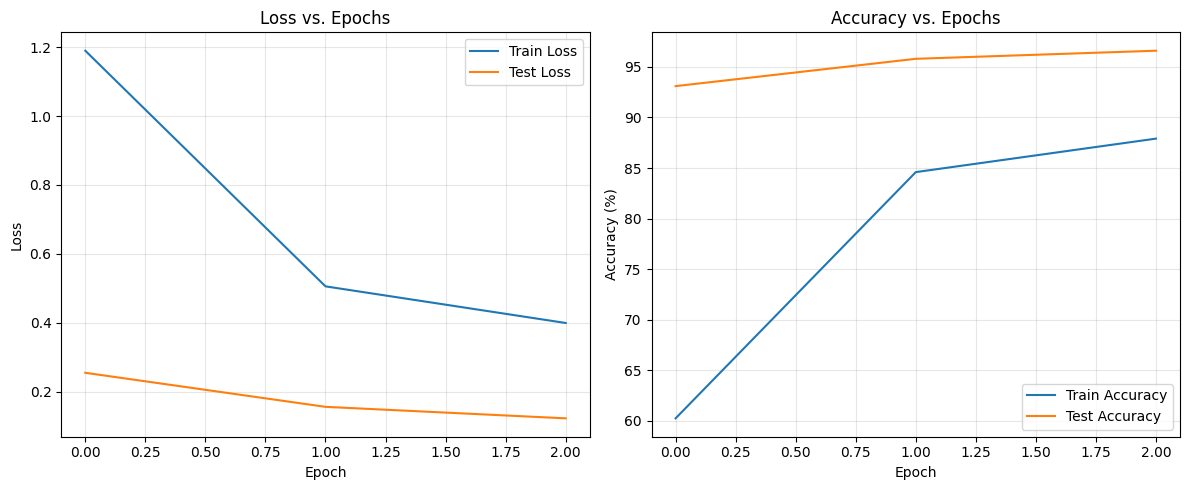

In [57]:
# Train for a few epochs
num_epochs = 3
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("\nStarting training loop...\n")

for epoch in range(1, num_epochs + 1):
    # Train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Test the model
    test_loss, test_acc = test(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Epoch {epoch} summary:')
    print(f'Training Loss: {train_loss:.4f} | Training Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
    print('-' * 60)

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
